# Clustering using Signal to Noise

So far I've:

1. Looked at the data and seen that there are lots of ISBN/countries to forecast and a lot of these combos have little and/or sparse demand
2. Looked at different single TS forecasting methods
3. Taken Holt-Winters forward and forecast a big chunk of Spain's data. The results were not very encouraging
4. Spoken to the Business and asked them what they think should be forecastable
5. Tried using unsupervised methods to identify clusters and see if these clusters are more forecastable than others. Again with little success.

My hypothesis is that the TS data is too irregular i.e. there is not a strong enough pattern in the data to be able to use "out of the box" forecasting methods.

In [1]:
#Import libraries

#This is the various helper functions that are common across all the notebooks
from helpers import *

import psycopg2
import numpy as np
import pandas as pd
import datetime as dt
import random
from statistics import variance

import random #I'm going to us this for dev and testing

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.seasonal import STL

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#This is suppress all warnings in the notebook - turn when happy code works
import warnings
warnings.filterwarnings('ignore')
#Alternative is %%capture --no-display

In [2]:
#Redshift user credentials - set here
USER = 
PASSWORD = 

FCST_PERIOD = 9   #How many months I want to forecast ahead

In [3]:
#Create SQLAlchemy engine for Redshift database
user = USER
password = PASSWORD
host=
port='5439'
dbname='prod'

url = "postgresql+psycopg2://{0}:{1}@{2}:{3}/{4}".format(user, password, host, port, dbname)
engine = create_engine(url)

# A Get Data for Analysis

Retrieve data from Redhsift then downselect to the key_list

## A.1 Get data from Redshift

Let's focus on Spain and select everything where there was some demand in the forecast period

This is the same dataset as used for the autoclustering in the previous notebook

In [4]:
query = f"""
select
     isbn + ship_to_country_key as key,
     sum(quantity_demanded) as qty_fcst_period
from r2ibp.f_demand_actual
where ship_to_country_key = 'ES'
and last_day(date) > dateadd(month, -{FCST_PERIOD}, current_date)
and last_day(date) <= current_date
and isbn not like '555%%'
group by key
"""
conn = engine.connect()
df_catalog = pd.read_sql_query(query, conn)
conn.close()

## A.2 Create the key_list

i.e. ISBN/countries to take forward in the analysis

In [5]:
#key_list = random.sample(list(df_catalog['key']), 100)
key_list = list(df_catalog['key'])

## A.3 Get Demand and Calc HWES Forecast

To produce these Holt-Winters forecasts from the dataframe took 0:05:29.432160
Tried to forecast 3072
Errored 0


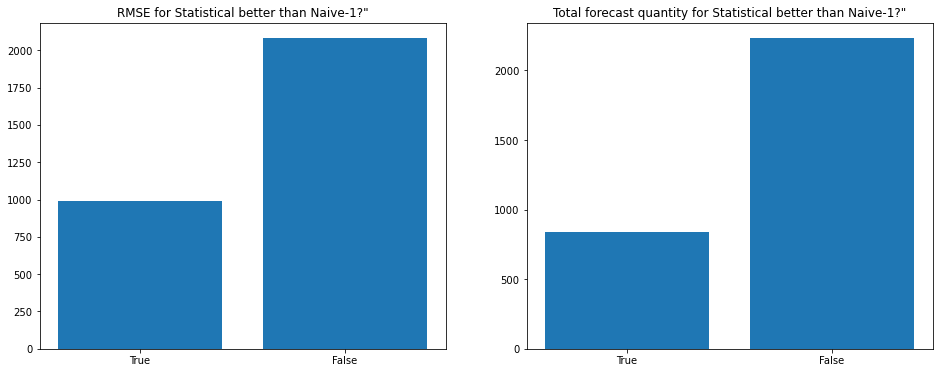

Total number of forecasts: 3072
RMSE Stastical lower than Naive-1: 991 (32.3%)


In [6]:
#This is standard across notebooks

df_demand = get_demand(key_list, engine)
df_errors, df_hwes_forecasts = predict_using_hwes(df_demand, FCST_PERIOD)
df_metrics = calc_prediction_metrics(df_hwes_forecasts, percent = True)
plot_pred_naive1(df_metrics)

# B. Calculate SNR and Strengths

## B.1 Helper Function

In [8]:
def calc_snr_trend_and_seasonality_strengths(ts):

    res = STL(ts).fit()
    
    signal = res.trend + res.seasonal
    noise = res.resid
    snr = np.mean(signal**2)/np.mean(noise**2)
    
    trend_strength = max(0, 1-variance(res.resid)/variance(res.trend + res.resid))
    seasonality_strength = max(0, 1-variance(res.resid)/variance(res.seasonal + res.resid))
    
    return snr, trend_strength, seasonality_strength

## B.2 Calculate the strength metrics

In [9]:
%%capture --no-display
#This stops all the warnings being printed but also the print()s!
#With all 3072 Spanish combos is takes about 6 minutes to run

#Generate the forecasts and add ts strengths and H-W alpha, beta and gamma to the clustering data

snr_list = []
trend_str_list = []
seasonal_str_list = []


for i, key in enumerate(key_list):   
    
    ts_actuals = convert_to_ts(df_demand[df_demand['key'] == key], FCST_PERIOD)
    
    #This should probably not include the forecast period (i.e. last 9 months)
    snr, trend_str, seasonal_str = calc_snr_trend_and_seasonality_strengths(ts_actuals)
    snr_list.append(snr)
    trend_str_list.append(trend_str)
    seasonal_str_list.append(seasonal_str)

data = {'key': key_list,
        'SNR': snr_list,
        'trend_str': trend_str_list,
        'seasonal_str': seasonal_str_list,
       }

df_HW = pd.DataFrame(data)

In [10]:
df_HW

,key,SNR,trend_str,seasonal_str
0,9788495986474ES,9.551461,0.619262,0.778925
1,9788495986801ES,10.131445,0.572219,0.715279
2,9781108380782ES,22.764261,0.884692,0.822286
3,9781108781558ES,35.483103,0.839864,0.869203
4,9788490362983ES,34.730250,0.386877,0.941152
...,...,...,...,...
3067,9780521479714ES,7.957583,0.557892,0.853975
3068,9780521549196ES,2.450223,0.202248,0.685337
3069,9788491794196ES,3.529951,0.522942,0.779166
3070,9788490362327ES,3.554909,0.331782,0.700146


## B.3 Let's Look at the Strength Metrics

,SNR,trend_str,seasonal_str
count,3.072000e+03,3072.000000,3072.000000
mean,1.070538e+28,0.466663,0.801909
std,5.933525e+29,0.228491,0.132962
min,6.057289e-01,0.008720,0.367079
25%,4.806251e+00,0.290757,0.731425
50%,8.312931e+00,0.448436,0.844460
75%,1.596512e+01,0.642122,0.891462
max,3.288693e+31,1.000000,1.000000


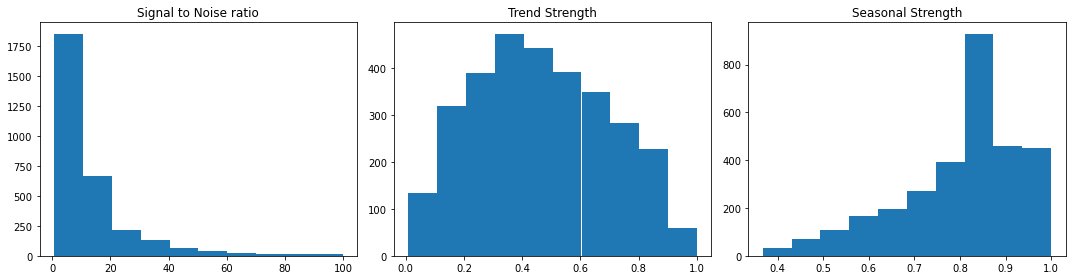

In [14]:
# Histograms of the five variables
plt.subplots(figsize = (15,4))

plt.subplot(131)
plt.hist(df_HW[df_HW['SNR'] < 100]['SNR']);
plt.title("Signal to Noise ratio")

plt.subplot(132)
plt.hist(df_HW['trend_str']);
plt.title("Trend Strength")

plt.subplot(133)
plt.hist(df_HW['seasonal_str']);
plt.title("Seasonal Strength")

plt.tight_layout();

df_HW.describe()

In [17]:
#Chop the right hand tail off the SNR figures to make pairplot
 
df_small = df_HW[df_HW['SNR'] < 100]
len(df_small)

3026

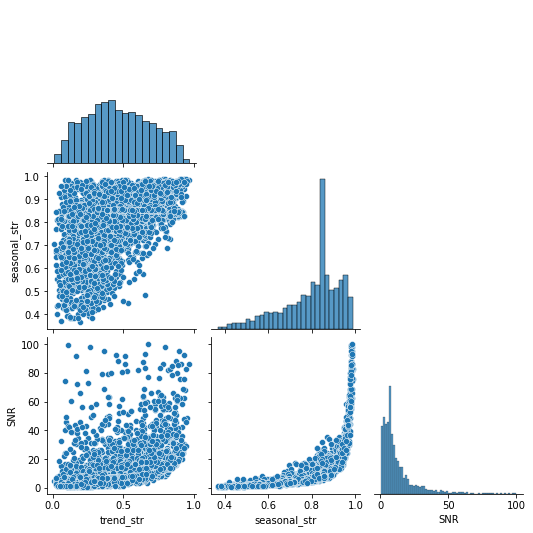

In [18]:
sns.pairplot(df_small[['trend_str', 'seasonal_str', 'SNR']], corner=True);

#Doesn't look like trend_str is giving us much
#Possibly replot this with SNR as hue

## Let's look at forecast accuracy c.f. signal strength

In [19]:
#Join metrics to df_HW

df_joined = df_HW.copy()

df_joined = df_joined.merge(df_metrics[['key', 'rmse_naive1', 'rmse_pred', 'pred_rmse_lower']], how = 'left')

#drop inf and nan
df_joined.replace([np.inf, -np.inf], np.nan, inplace=True)
df_joined. dropna(inplace=True)

df_joined.sort_values(by='seasonal_str', ascending = False).head(12)

,key,SNR,trend_str,seasonal_str,rmse_naive1,rmse_pred,pred_rmse_lower
2855,9781108815116ES,3.288693e+31,1.000000,1.000000,16.7,24.0,False
2249,9788413222349ES,1.900348e+05,0.999967,0.999995,33.3,1768.2,False
306,9788413222288ES,4.493235e+04,0.999860,0.999979,33.3,1579.2,False
420,9788490369746ES,8.338725e+03,0.999235,0.999886,57.7,1016.6,False
2229,9788490364024ES,7.352638e+03,0.998173,0.999863,0.0,128.0,False
2434,9781316627181ES,3.001651e+03,0.997197,0.999678,33.3,174.2,False
2234,9781316627532ES,2.801778e+03,0.997342,0.999658,33.3,183.4,False
112,9788413224541ES,8.761532e+02,0.994336,0.998897,17.1,293.7,False
126,9781108814928ES,6.364519e+02,0.983418,0.998414,55.0,187.8,False
2137,9780521279796ES,5.946668e+02,0.944275,0.998092,37.3,441.1,False


In [22]:
#As before crop the larger values for pairplot

df_selected = df_joined.copy()

df_selected = df_selected[(df_selected['SNR'] < 100) & (df_selected['rmse_pred'] < 200)]
df_selected

,key,SNR,trend_str,seasonal_str,rmse_naive1,rmse_pred,pred_rmse_lower
0,9788495986474ES,9.551461,0.619262,0.778925,31.1,22.9,True
1,9788495986801ES,10.131445,0.572219,0.715279,12.4,10.1,True
2,9781108380782ES,22.764261,0.884692,0.822286,14.7,15.8,False
3,9781108781558ES,35.483103,0.839864,0.869203,7.2,7.3,False
4,9788490362983ES,34.730250,0.386877,0.941152,22.8,22.7,True
...,...,...,...,...,...,...,...
3067,9780521479714ES,7.957583,0.557892,0.853975,23.6,23.6,False
3068,9780521549196ES,2.450223,0.202248,0.685337,47.1,45.5,True
3069,9788491794196ES,3.529951,0.522942,0.779166,47.1,44.4,True
3070,9788490362327ES,3.554909,0.331782,0.700146,33.3,76.0,False


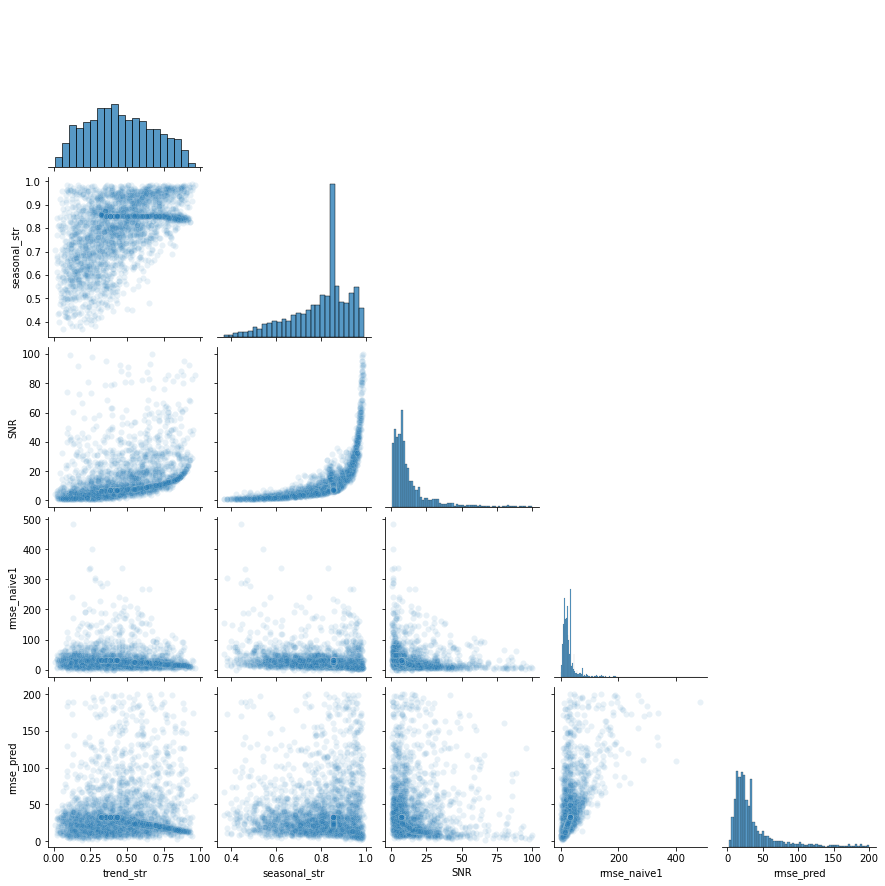

In [23]:
sns.pairplot(df_selected[['trend_str', 'seasonal_str', 'SNR', 'rmse_naive1', 'rmse_pred']],
             plot_kws = {"alpha" :0.1}, corner=True);

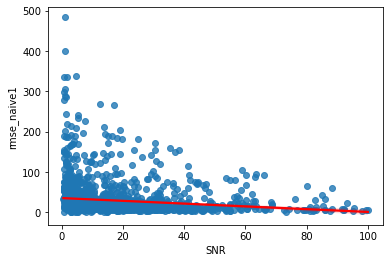

In [24]:
#OK I want to plot a simple linear regression of rmse_naive1 and rmse_pred against SNR
#You can use sns

x = df_selected['SNR']
y = df_selected['rmse_naive1']

#sns.regplot(x, y, ci=None);
sns.regplot(x,y, line_kws = {"color": "red"});

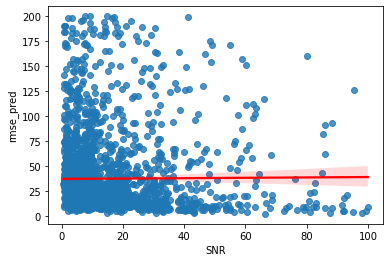

In [25]:
x = df_selected['SNR']
y = df_selected['rmse_pred']

sns.regplot(x,y, line_kws = {"color": "red"});

#OK I need to think about how to use this i.e.
#What's the significance of the naive-1 being clustered tighter and being (slightly) more stronngly correlated to SNR

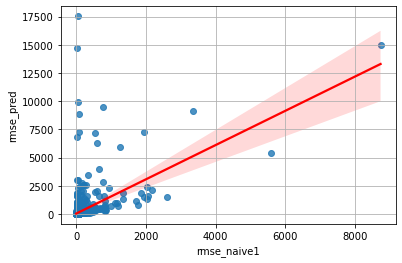

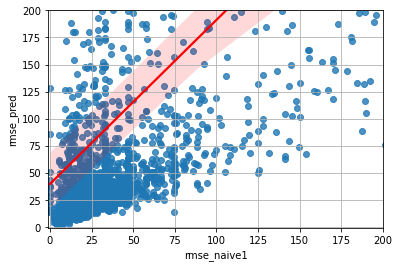

In [26]:
x = df_joined['rmse_naive1']
y = df_joined['rmse_pred']

sns.regplot(x,y, line_kws = {"color": "red"});
plt.grid()
plt.show();

#Focus down to the smaller values

sns.regplot(x,y, line_kws = {"color": "red"});
plt.grid()
plt.xlim(-1,200)
plt.ylim(-1,200)
plt.show();

#You can clearly see that naive-1 is a generlly better forecast (points below the fit line)

# F Timeseries Plots

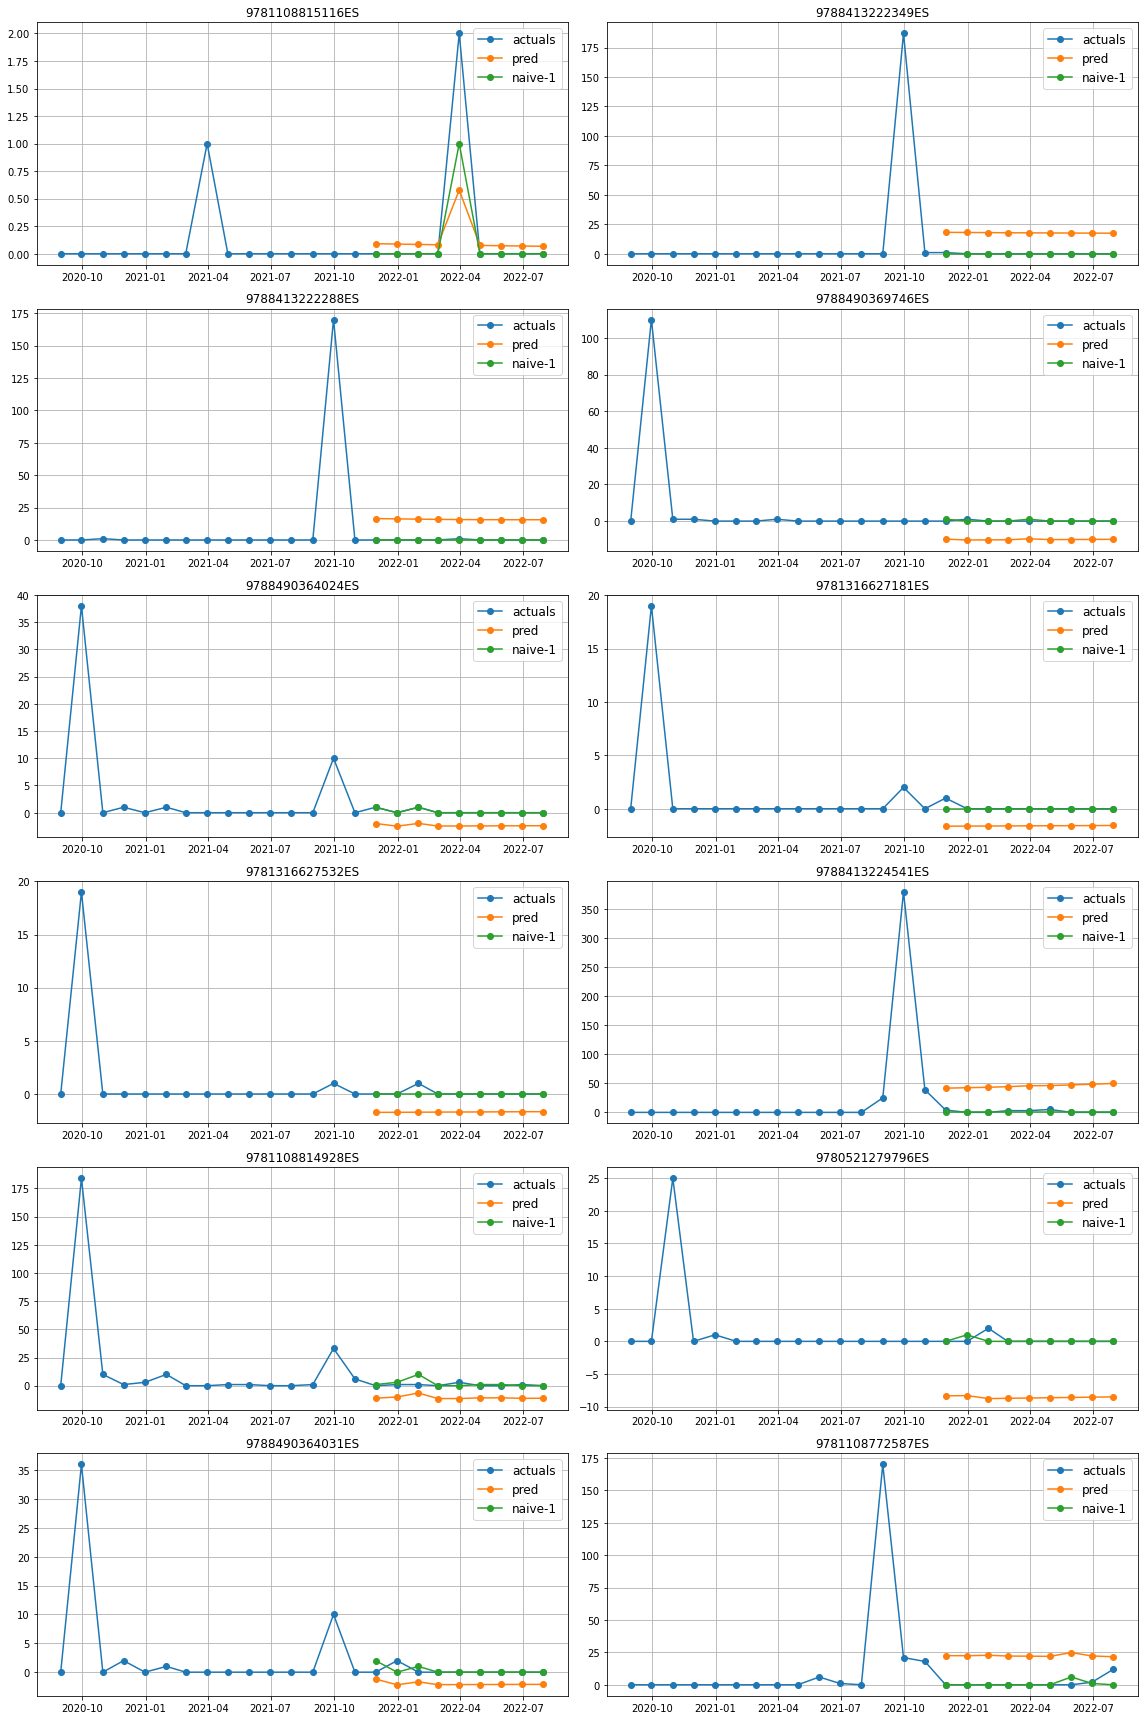

,key,sum_naive1,sum_pred,sum_act,diff_naive1_act,diff_pred_act,abs_pred_closer,rmse_naive1,rmse_pred,pred_rmse_lower,rmse_pc_diff
2098,9780521279796ES,1.0,-77.1,2.0,-50.0,-3957.2,False,37.3,441.1,False,1082.6
2163,9781108772587ES,7.0,202.6,14.0,-50.0,1347.0,False,32.0,152.6,False,376.9
2351,9788490364024ES,2.0,-21.0,2.0,0.0,-1147.5,False,0.0,128.0,False,inf
2352,9781316627181ES,0.0,-14.4,1.0,-100.0,-1540.3,False,33.3,174.2,False,423.1
2353,9788490369746ES,2.0,-90.4,1.0,100.0,-9140.7,False,57.7,1016.6,False,1661.9
2354,9788490364031ES,3.0,-17.9,2.0,50.0,-993.3,False,50.0,116.8,False,133.6
2365,9781108814928ES,16.0,-94.3,6.0,166.7,-1671.0,False,55.0,187.8,False,241.5
2367,9781316627532ES,0.0,-15.3,1.0,-100.0,-1625.0,False,33.3,183.4,False,450.8
2386,9788413222288ES,0.0,143.1,1.0,-100.0,14206.5,False,33.3,1579.2,False,4642.3
2465,9781108815116ES,1.0,1.2,2.0,-50.0,-39.4,True,16.7,24.0,False,43.7


In [27]:
plot_list = df_joined.sort_values(by='seasonal_str', ascending = False).head(12)['key'].to_list()

plot_sample_preds(plot_list, df_demand, df_hwes_forecasts, FCST_PERIOD)

df_metrics[df_metrics['key'].isin(plot_list)]

In [ ]:
#With high SNRs the prediction closely tracks naive-1 - the problem is that it can't do (consistently) better
#This is because the underlying trend is all over the place

#With low SNRs the predictions and naive-1 are both crap but it seems that at least for RMSE the HW does a better job
#Presumably by luck or maybe by picking up a change to the underlying trend